# Retención de clientes (Churn) con ML en  PySpark. Avanzado

#### Tipo de Problema
**Objetivo:** Prediccion del churn de Cliente, para tratar de mantener el cliente o fidelizarlo

**Tipo de modelo de ML:** supervisado y clasificación binaria

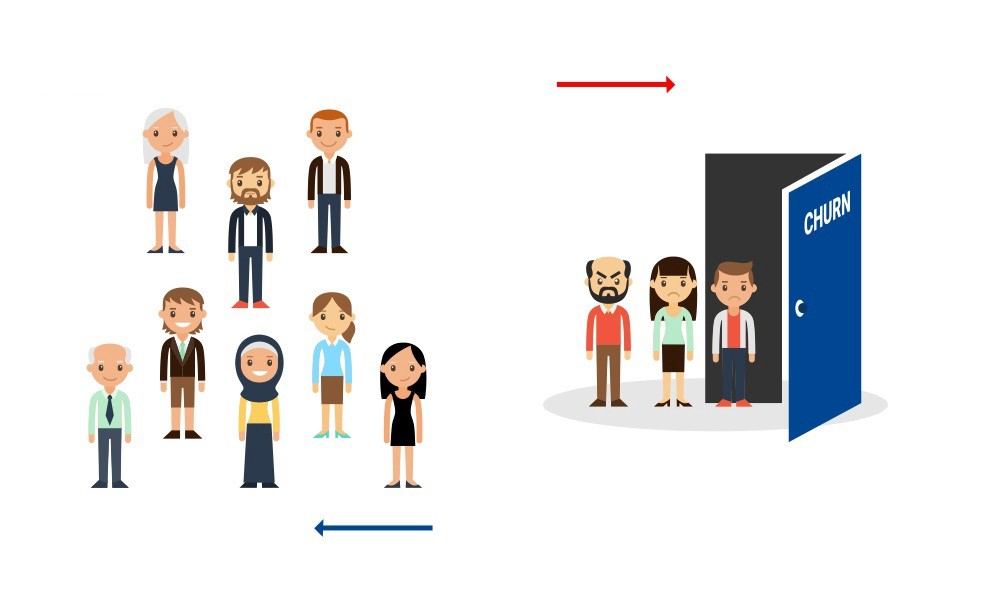

### Fase 1. Importación de datos en Spark

In [136]:
import findspark
findspark.init()
import pandas as pd
import pyspark

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.feature import MinMaxScaler


#### Iniciar sesion de Spark

In [137]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName('churnanalysis') \
    .getOrCreate()

In [138]:
df = (spark.read
          .format("csv")
          .option('header', 'true')
          .load("Churn_Modelling.csv"))

In [139]:
df.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|        0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|        0|            2|        0|             0|       93826.63|

In [140]:
df.printSchema()

root
 |-- RowNumber: string (nullable = true)
 |-- CustomerId: string (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: string (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Tenure: string (nullable = true)
 |-- Balance: string (nullable = true)
 |-- NumOfProducts: string (nullable = true)
 |-- HasCrCard: string (nullable = true)
 |-- IsActiveMember: string (nullable = true)
 |-- EstimatedSalary: string (nullable = true)
 |-- Exited: string (nullable = true)



In [141]:
df.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|        0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|        0|            2|        0|             0|       93826.63|

In [142]:
df.count()

10000

In [143]:
df.dtypes

[('RowNumber', 'string'),
 ('CustomerId', 'string'),
 ('Surname', 'string'),
 ('CreditScore', 'string'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Age', 'string'),
 ('Tenure', 'string'),
 ('Balance', 'string'),
 ('NumOfProducts', 'string'),
 ('HasCrCard', 'string'),
 ('IsActiveMember', 'string'),
 ('EstimatedSalary', 'string'),
 ('Exited', 'string')]

In [144]:
# Basics stats from our columns
df.describe().toPandas()

,summary,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,mean,5000.5,1.56909405694E7,None,650.5288,None,None,38.9218,5.0128,76485.88928799961,1.5302,0.7055,0.5151,100090.2398809998,0.2037
2,stddev,2886.8956799071675,71936.18612274907,None,96.65329873613035,None,None,10.487806451704587,2.8921743770496837,62397.40520238599,0.5816543579989917,0.45584046447513327,0.49979692845891815,57510.49281769821,0.40276858399486065
3,min,1,15565701,Abazu,350,France,Female,18,0,0,1,0,0,100015.79,0
4,max,9999,15815690,Zuyeva,850,Spain,Male,92,9,99986.98,4,1,1,99984.86,1


#### Ajustar tipo de datos

In [145]:
from pyspark.sql.functions import col
dataset = df.select(col('CreditScore').cast('float'),
                         col('Age').cast('float'),
                         col('Tenure').cast('float'),
                         col('NumOfProducts').cast('float'),
                         col('HasCrCard').cast('float'),
                         col('IsActiveMember').cast('float'),
                         col('EstimatedSalary').cast('float'),
                         col('Balance').cast('float'),
                         col('Geography'),
                         col('Gender'),
                         col('Exited').cast('float')
                        )
dataset.head(5)

dataframe=dataset.toPandas().head()

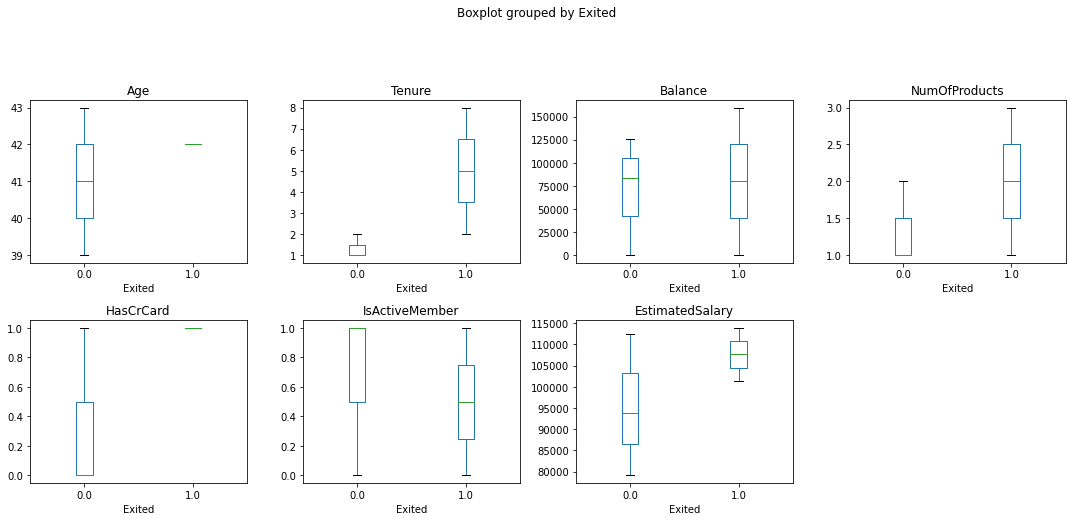

In [146]:
import matplotlib.pyplot as plt
plot_columns = ['CreditScore', 
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']
plot_columns

# Displays ranges, percentiles, and averages of users that churned vs those that did not churn per page type
fig = plt.figure(figsize=(15, 20))

for i in range(1,len(plot_columns)):
    axis = fig.add_subplot(6,4,i)
    dataframe.boxplot(plot_columns[i], ax = axis, grid = False,  by='Exited', showfliers=False)
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### Fase 2. Pre-procesamiento de datos

#### Eliminar columnas innecesarias

In [147]:
# Drop unnecessary columns
dataset = dataset.drop('RowNumber')
dataset = dataset.drop('CustomerId')
dataset = dataset.drop('Surname')

dataset.head(5)

[Row(CreditScore=619.0, Age=42.0, Tenure=2.0, NumOfProducts=1.0, HasCrCard=1.0, IsActiveMember=1.0, EstimatedSalary=101348.8828125, Balance=0.0, Geography='France', Gender='Female', Exited=1.0),
 Row(CreditScore=608.0, Age=41.0, Tenure=1.0, NumOfProducts=1.0, HasCrCard=0.0, IsActiveMember=1.0, EstimatedSalary=112542.578125, Balance=83807.859375, Geography='Spain', Gender='Female', Exited=0.0),
 Row(CreditScore=502.0, Age=42.0, Tenure=8.0, NumOfProducts=3.0, HasCrCard=1.0, IsActiveMember=0.0, EstimatedSalary=113931.5703125, Balance=159660.796875, Geography='France', Gender='Female', Exited=1.0),
 Row(CreditScore=699.0, Age=39.0, Tenure=1.0, NumOfProducts=2.0, HasCrCard=0.0, IsActiveMember=0.0, EstimatedSalary=93826.6328125, Balance=0.0, Geography='France', Gender='Female', Exited=0.0),
 Row(CreditScore=850.0, Age=43.0, Tenure=2.0, NumOfProducts=1.0, HasCrCard=1.0, IsActiveMember=1.0, EstimatedSalary=79084.1015625, Balance=125510.8203125, Geography='Spain', Gender='Female', Exited=0.0)]

#### Valores vacios

In [148]:
from pyspark.sql.functions import isnull, when, count, col
dataset.select([count(when(isnull(c), c)).alias(c) for c in dataset.columns]).show()

# Drop missing values
dataset = dataset.replace('null', None)\
        .dropna(how='any')

+-----------+---+------+-------------+---------+--------------+---------------+-------+---------+------+------+
|CreditScore|Age|Tenure|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Balance|Geography|Gender|Exited|
+-----------+---+------+-------------+---------+--------------+---------------+-------+---------+------+------+
|          0|  0|     0|            0|        0|             0|              0|      0|        0|     0|     0|
+-----------+---+------+-------------+---------+--------------+---------------+-------+---------+------+------+



#### De variables categoricas a numericas

In [149]:
from pyspark.ml.feature import StringIndexer

# list of numerical columns
numerical_cols =['CreditScore',
                 'Age',
                 'Tenure',
                 'NumOfProducts',
                 'HasCrCard',
                 'IsActiveMember',
                 'EstimatedSalary',
                 'Balance']

# convert sting column to index column
indexer = StringIndexer(inputCol='Geography', outputCol='GeographyIndex', handleInvalid='skip')
indexer2 = StringIndexer(inputCol='Gender', outputCol='GenderIndex', handleInvalid='skip')

inputs = [indexer.getOutputCol()]


# one hot encode categorical columns to numerical vector columns
encoder = OneHotEncoder(inputCol='GeographyIndex', outputCol='GeographyNumVec', handleInvalid='keep')

In [150]:
# transform numerical columns to a single vector column
num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='num_features')

# apply scaler (MinMax scaler preserves original data distribution)
scaler = MinMaxScaler(inputCol='num_features', outputCol='scaled_features')

In [151]:
# transform all create vector columns into one vector column
assembler = VectorAssembler(inputCols=['GenderIndex', 'scaled_features', 'GeographyNumVec'], \
                            outputCol='features')

In [152]:
# create pipeline with above steps
data_pipeline = Pipeline(stages=[indexer, indexer2,encoder, num_assembler, scaler, assembler])

### Fase 3. Entrenamiento del modelo


#### Train Test Split

In [153]:
# fit pipeline and transform dataframe
dataset = data_pipeline.fit(dataset).transform(dataset)

In [154]:
# split data into train, validation and test sets
train, validation_test = dataset.randomSplit([0.7, 0.3], seed = 4)
validation, test = validation_test.randomSplit([0.5, 0.5], seed = 4)


print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 6969
Test Dataset Count: 1508


#### Modelo de clasificación simple (baseline accuracy)

In [155]:
from pyspark.ml.classification import *
from time import *

# instantiate and train naive bayes
start = time()
nb = NaiveBayes(featuresCol='features', labelCol='Exited')

nb_model = nb.fit(train)
end = time()
print('Total training time for naive bayes: {} seconds'.format(end-start))
predictions = nb_model.transform(test)

Total training time for naive bayes: 1.0493290424346924 seconds


In [156]:
# Evaluate our model
from pyspark.ml.evaluation import *

evaluator = MulticlassClassificationEvaluator(
    labelCol='Exited', 
    predictionCol='prediction', 
    metricName='accuracy')

# Accuracy
accuracy = evaluator.evaluate(predictions)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.7858090185676393


#### Multiples modelos

In [157]:
# instantiate and train naive bayes
start = time()

nb = NaiveBayes(featuresCol='features', labelCol='Exited')
nb_model = nb.fit(train)

lr = LogisticRegression(featuresCol='features', labelCol='Exited')
lr_model = lr.fit(train)

svc = LinearSVC(featuresCol='features', labelCol='Exited')
svc_model = svc.fit(train)

rf = RandomForestClassifier(featuresCol='features', labelCol='Exited')
rf_model = rf.fit(train)

dt = DecisionTreeClassifier(featuresCol='features', labelCol='Exited')
dt_model = dt.fit(train)

gbt = GBTClassifier(featuresCol='features', labelCol='Exited')
gbt_model = gbt.fit(train)

end = time()
print('Total training time for naive bayes: {} seconds'.format(end-start))
predictions = nb_model.transform(test)

Total training time for naive bayes: 23.650386810302734 seconds


In [158]:
# make baseline model predictions
# create lists with the models and their respective names
models = [nb_model, 
          lr_model, 
          svc_model, 
          rf_model, 
          dt_model,
          gbt_model]

model_names = ['naive bayes', 
               'logistic regression', 
               'linear svc', 
               'random forest', 
               'decision tree',
                'Gradient Boosting']

# for all models, make prediction, calculate f1 and area under the PR scores and display results
for i in range(len(models)):
    model = models[i]
    model_name = model_names[i]
    
    # predict on validation set
    validation_prediction = model.transform(validation)
 
    # use MulticlassClassificationEvaluator to get f1 scores
    evaluator1 = MulticlassClassificationEvaluator(labelCol='Exited')
 
    # use BinaryClassificationEvaluator to get area under PR 
    evaluator2 = BinaryClassificationEvaluator(
                 rawPredictionCol='prediction', labelCol='Exited')
    # make evaluation and print f1 and area under PR score per model
    print('')
    print('F1 score for {} on validation set:{}'.format(\
          (model_name), \
          (evaluator1.evaluate(validation_prediction, {evaluator1.metricName:'f1'}))))
 
    print('Area under PR for {} on validation set: {}'.format((model_name), \
          (evaluator2.evaluate(validation_prediction,{evaluator2.metricName:'areaUnderPR'}))))


F1 score for naive bayes on validation set:0.7034953015825882
Area under PR for naive bayes on validation set: 0.20551543007222586

F1 score for logistic regression on validation set:0.7709639390175973
Area under PR for logistic regression on validation set: 0.44768138939289115

F1 score for linear svc on validation set:0.7034953015825882
Area under PR for linear svc on validation set: 0.20551543007222586

F1 score for random forest on validation set:0.8256835066969397
Area under PR for random forest on validation set: 0.6172305095388634

F1 score for decision tree on validation set:0.8353721445204387
Area under PR for decision tree on validation set: 0.5564293809995146

F1 score for Gradient Boosting on validation set:0.8461074612633692
Area under PR for Gradient Boosting on validation set: 0.6201329837571375


#### Ajuste de hiperparametros

In [159]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# tune hyperparameters with ParamGridBuilder and CrossValidator
# build paramGrid with hyperparameters to tune
paramGrid = (ParamGridBuilder()
            .addGrid(rf.impurity,['entropy', 'gini']) #default: gini
            .addGrid(rf.maxDepth, [5, 10, 15]) #default: 5
            .build())

# add paramGrid to CrossValidator
crossval = CrossValidator(estimator = rf,
   estimatorParamMaps = paramGrid,
   evaluator = MulticlassClassificationEvaluator(labelCol='Exited'),
               numFolds = 3)

# fit cv model and train it
start = time()
cv_rf = crossval.fit(train)
end = time()
print('Total training time for hyperparameter tuning on random forest model: {} seconds'.format(end-start))

Total training time for hyperparameter tuning on random forest model: 50.541481494903564 seconds


In [162]:
# fit cv model and train it
start = time()

paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .addGrid(gbt.maxIter,[5, 10]) \
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=MulticlassClassificationEvaluator(labelCol='Exited',metricName='f1'),
                          numFolds=3)

# fit cv model and train it
start = time()
cvModel_gbt  = crossval.fit(train)
end = time()
print('Total training time for hyperparameter tuning on random forest model: {} seconds'.format(end-start))

Total training time for hyperparameter tuning on random forest model: 65.72379469871521 seconds


### Fase 4. Evaluación del modelo

In [168]:
# use MulticlassClassificationEvaluator to get f1 scores
evaluator = MulticlassClassificationEvaluator(labelCol='Exited')


# test baseline random forest model on test set
# predict on test set
test_prediction_rf_baseline = rf_model.transform(test)

# make evaluation and print f1-score
print('')
print('F-1 Score for baseline random forest model on test set: {}'.format(evaluator.evaluate(
            test_prediction_rf_baseline, {evaluator.metricName:'f1'})))



# predict on test set
test_prediction_rf = cv_rf.transform(test)

# make evaluation and print f1-score
print('')
print('F-1 Score for tuned random forest model on test set: {}'.format(evaluator.evaluate(
    test_prediction_rf, {evaluator.metricName:'f1'})))




# predict on validation set
validation_prediction_rf = cv_rf.transform(validation)

# make evaluation and print f1-score
print('')
print('F-1 Score for tuned random forest model on validation set: {}'.format(evaluator.evaluate(
 validation_prediction_rf, {evaluator.metricName:'f1'})))



F-1 Score for baseline random forest model on test set: 0.8366839526730204

F-1 Score for tuned random forest model on test set: 0.8412479884238896

F-1 Score for tuned random forest model on validation set: 0.8423227808008871


In [169]:
results_final = cvModel_gbt.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol='Exited')
print('Test Set Prediction Metrics:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))
print('')

# predict on validation set
results_final = cvModel_gbt.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol='Exited')
print('Validation Set Prediction Metrics:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))

Test Set Prediction Metrics:
F-1 Score:0.8452873374260257
Accuracy: 0.8574270557029178

Validation Set Prediction Metrics:
F-1 Score:0.8377750935182053
Accuracy: 0.8522652659225214


#### Feature Importance

In [193]:
import numpy as np
# Displays features that are most predictive of the label in the model

feature_names = train.drop('Exited','GeographyIndex','Geography','Gender','num_features','scaled_features').columns
feature_importances = np.array(gbt_model.featureImportances)
userAgentVec = feature_importances[len(feature_names) :].sum()
feature_importances = feature_importances[:len(feature_names)] + [userAgentVec]


In [196]:
# Converts feature importance data to a pandas dataframe
feature_importance = pd.DataFrame(feature_importances, \
                                     index = feature_names,\
                                     columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Tenure'),
  Text(1, 0, 'HasCrCard'),
  Text(2, 0, 'GenderIndex'),
  Text(3, 0, 'EstimatedSalary'),
  Text(4, 0, 'CreditScore'),
  Text(5, 0, 'Age'),
  Text(6, 0, 'Balance'),
  Text(7, 0, 'features'),
  Text(8, 0, 'NumOfProducts'),
  Text(9, 0, 'GeographyNumVec'),
  Text(10, 0, 'IsActiveMember')])

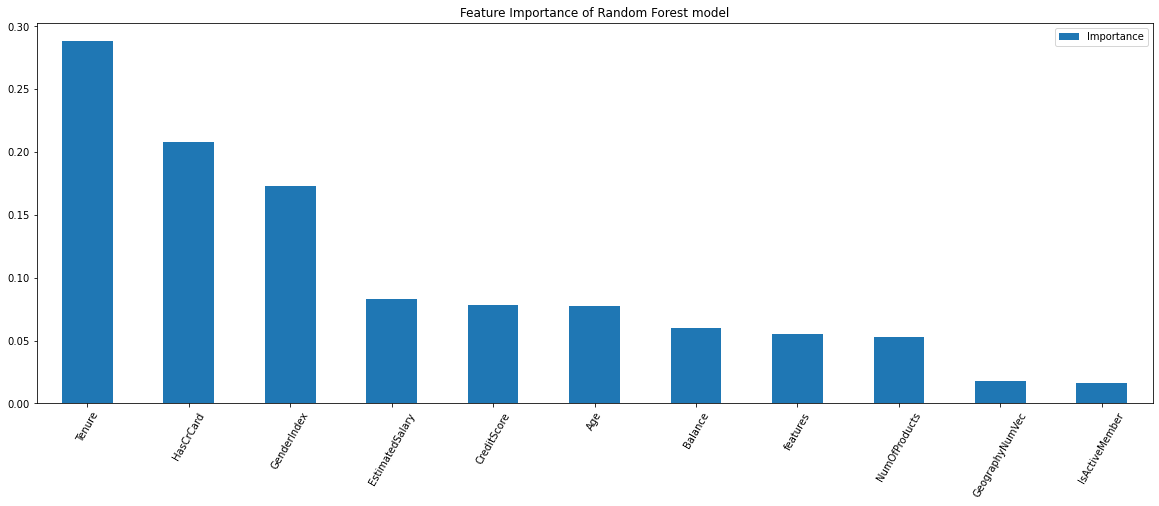

In [197]:
feature_importance.plot(kind = 'bar', figsize = (20, 7), title = 'Feature Importance of Random Forest model')
plt.xticks(rotation = 60)